<a href="https://colab.research.google.com/github/cbmoliveira/Imagem/blob/main/An%C3%A1lise_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Imagem utilizando Python**

Microtomogradia de Raios-X tem sido bastante utilizada no estudo de soloss, principalmente pela não destruição de amostras. Ao montar as imagens em 'stacks' temos imagens 3D. Abaixo se encontra um exemplo de como uma amostra de solo pode ser processada e analisada utilizando Python. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#gráfico estático
%matplotlib inline
import glob #importa imagem em sequência
from PIL import Image #criar, carregar imagens
import numpy as np #Cálculo em arrays multidimensionais
from scipy import ndimage #processa imagens em várias dimensões
import matplotlib.pyplot as plt #criar os gráficos
from skimage.io import imsave #lê imagens em vários formatos

In [3]:
import time #ter noção do tempo
t=time.time()

Para trabalhar com imagens 3D, é preciso importar e as colocar em stacks sucessivamente, isso é feito através de um container de arrays 3D com os valores das imagens, e importação dos valores dos pixels num array. Cada valor desse array representa o valor correspondendo do voxel em 3D na imagem. 

In [4]:
#carregar as imagens numa lista de acordo com seu nome
infiles = sorted(glob.glob('/content/drive/MyDrive/TC/ten/*.tif'))

#abri a primeira imagem para pegar seus dados
im = Image.open(infiles[0])

#array zerada para ser preenchida de acordo com os tamanhos das imagens (slices, largura, comprimento)
imgs = np.zeros((len(infiles),im.size[1],im.size[0]))

#Loop que irá adicionando as imagens no array.
i=0
for imfile in infiles:
  im = Image.open(imfile)
  imgs[i,:,:] = np.array(im)
  i+=1

Agora todas as imagens estão no array 3D, nomeado "imgs", que seria o equivalente ao objeto real digitalizado.

# Pre-processamento

Aqui serão incluídos passos como filtros, redimensionamentos, que são passos para o processamento posterior das imagens. Esses passos são importantes por para a segmentação das imagens, é importante ter a melhor qualidade de imagem possível.

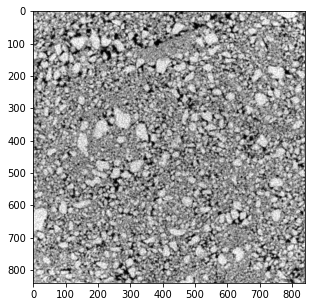

In [5]:
from scipy import stats
#Calcula o score de um dado percentil de um sequência, valores fora disso serão ignorados. 
vmin, vmax = np.percentile(imgs,(0.5,99.5))

#Redimensionamento já que o scikit precisa que as imagens tenham valores entre 0 e 1
imgs = np.clip(imgs, vmin, vmax)
imgs = (imgs - vmin) / (vmax - vmin)

#Encontrar objetos 
fdg = imgs > 0.4 
obj = ndimage.find_objects(fdg)
sample = imgs[obj[0]]

#mostra a primeira imagem do stack
plt.figure(figsize=(5,5))
plt.imshow(sample[0],cmap='gray')
plt.show()


# De-noising

É um processo que reduz ruídos e artefatos na imagem. A qualidade da imagem está muito boa, fora alguns ruídos no estilo "sal e pimenta". Para essa imagem poderiam ser utilizados filtros, como median, non-local-means e FFT. As vezes é preciso um conjunto de filtros, conversões e ajustes para que a qualidade seja superior.

Será utilizado o **scikit-image**, que é um conjunto de algoritmos para processamento de imagens. 

In [6]:
from skimage import restoration

#filtro bilateral para retirar o ruído 'sal e pimenta'das imagens
bilateral = restoration.denoise_bilateral(sample, multichannel=True)
#filtro baseado no algoritmo de Rudin, Fatemi e Osher, proposto por Chambolle
tv = restoration.denoise_tv_chambolle(sample,weight=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The last axis of the input image is interpreted as channels. Input image with shape (10, 840, 840) has 840 channels in last axis. ``denoise_bilateral`` is implemented for 2D grayscale and color images only
  after removing the cwd from sys.path.


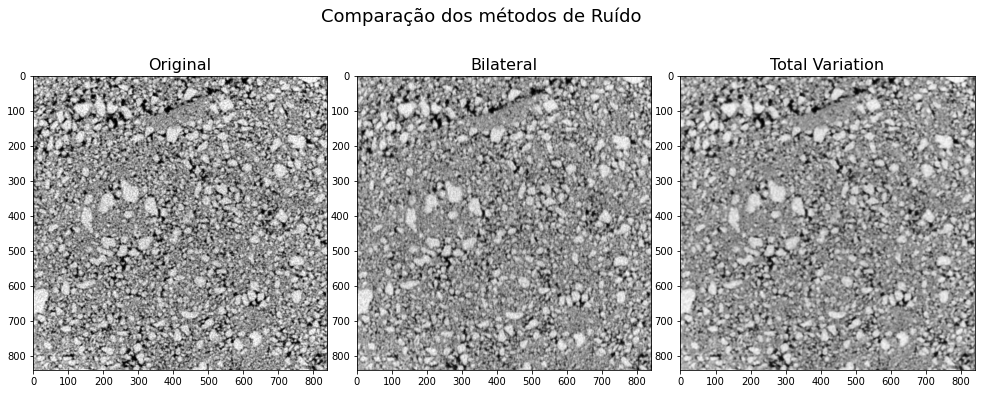

In [7]:
#Gráficos de comparação dos métodos
fig, axes = plt.subplots(nrows=1, ncols=3)
ax0, ax1, ax2 = axes
fig.suptitle('Comparação dos métodos de Ruído', y=0.70, fontsize=18)
ax0.imshow(sample[0],cmap='gray')
ax0.set_title('Original',fontsize=16)
ax1.imshow(bilateral[0],cmap='gray')
ax1.set_title('Bilateral',fontsize=16)
ax2.imshow(tv[0],cmap='gray')
ax2.set_title('Total Variation',fontsize=16)
plt.tight_layout()
fig.set_size_inches(15, 15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)


In [8]:
#Atualização da Array para sem ruídos
sample = tv 

# Segmentação

Segmentação é uma operação que classifica objetos em fases, nesse caso as fases são: preto = vazios, tons de cinza= matriz + sólidos.

Primeiro vamos encontrar essas fases através do histograma das imagens.

Text(0.5, 1.0, 'Histograma')

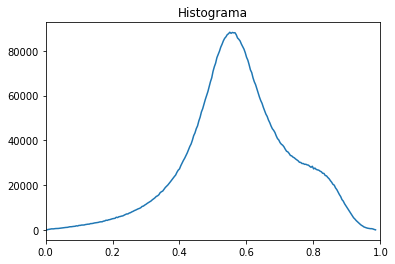

In [9]:
#Histograma das imagens, para que os valores sejam tomados
from skimage import exposure 
histo=exposure.histogram(sample) # Retorna o histograma da imagem
#plotagem do histograma
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0,1)
plt.title('Histograma')

Você deverá encontrar o threshold de cada fase de forma manualmente, e ir ajustando de acordo com os marcadores que você for definindo. É um passo que precisa de repetição até você encontrar o melhor resultado.

Text(0.8, 78246.0, 'Sólidos')

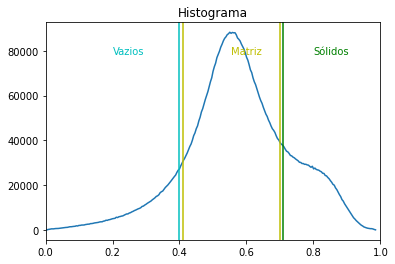

In [16]:
#Marcar as áreas de interesse
void=0.4
matrixmin=0.41
matrixmax=0.7
solid=0.71

#Histograma
from skimage import exposure
histo = exposure.histogram(sample) #plot o histograma de acordo com a imagem
plt.plot(histo[1], histo[0], label='data')
plt.xlim(0, 1)
plt.title('Histograma')
plt.axvline(void, color='c', ls='-')
plt.axvline(matrixmin, color='y', ls='-')
plt.axvline(matrixmax, color='y', ls='-')
plt.axvline(solid, color='g', ls='-')
plt.text(void/2, np.max(histo)-10000, 'Vazios', color='c')
plt.text((matrixmin+matrixmax)/2, np.max(histo)-10000, 'Matriz', color='y')
plt.text(0.8, np.max(histo)-10000, 'Sólidos', color='g')

Quando os limites forem estabelecidos, será criada um array com as marcações, que vai ter as mesmas dimensões de 'sample' com as marcações.

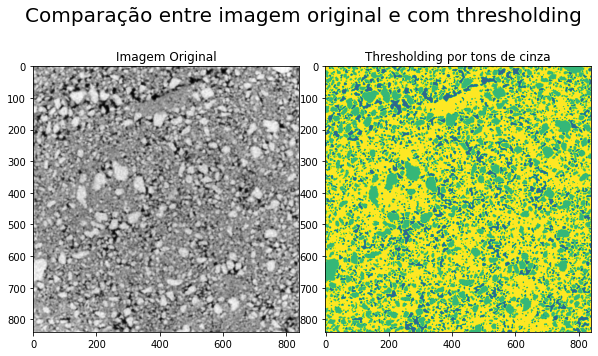

In [19]:
#Utilizando os marcadores na imagem
markers = np.zeros(sample.shape, dtype=np.int8) #array zerada
markers[sample < void] = 1 #vazios
markers[np.logical_and(sample > matrixmin, sample < matrixmax)] = 3 #matriz
markers[sample > solid] = 2 #solids

#Visualização dos marcadores
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
ax0, ax1= axes
ax0.imshow(sample[0], cmap='gray')
ax0.set_title("Imagem Original")
ax1.imshow(markers[0])
ax1.set_title("Thresholding por tons de cinza")
fig.suptitle('Comparação entre imagem original e com thresholding', y=0.77, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

O olho humano pode iludir e por isso o threshold global não é indicado. 

Segmentação utilizando marcadores como 'sementes', no qual o algoritmo vai difundindo as sementes até que eles chegam a determinada condição, como por exemplo o threshold do gradiente que são mais confiáveis. Como exemplos de segmentação, serão utilizados o Random Walker, Watershed e o K-means clustering. Os dois primeiros são baseados em algoritmos de segmentação com marcadores, utilizando os tons de cinza para isso. Já o K-mens usa um algoritmo independente de marcador. 

In [22]:
#Random Walker
from skimage import segmentation
rw = segmentation.random_walker(sample, markers, beta=500, mode='bf', copy=False, return_full_prob=False)#beta=diffusion difficulty
#generate possibility map
pm = segmentation.random_walker(sample, markers, beta=500, mode='bf', copy=False, return_full_prob=True)#beta=diffusion difficulty
#Watershed
from skimage.morphology import watershed as ws
ws = ws(sample, markers)
#K-means clustering
from skimage.segmentation import slic
km = slic(sample, n_segments=4, compactness=0.01, multichannel=False, enforce_connectivity=False)


Agora comparar os resultados e visualizar um mapa de probabilidade:

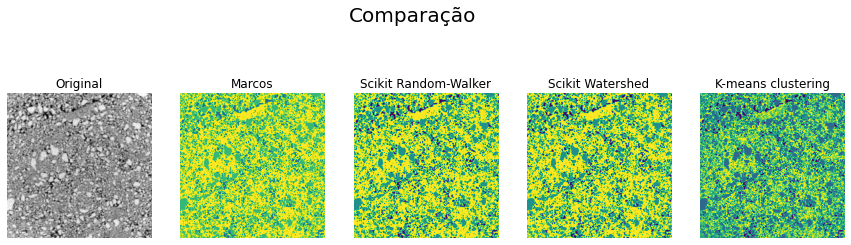

In [23]:
#Comparação entre as segmentações
fig, axes = plt.subplots(nrows =1, ncols=5, figsize=(15, 15))
ax0, ax1, ax2, ax3, ax4 = axes
ax0.imshow(sample[0], cmap='gray')
ax0.set_title("Original")
ax0.axis('off')
ax1.imshow(markers[0])
ax1.set_title('Marcos',fontsize=12)
ax1.axis('off')
ax2.imshow(rw[0])
ax2.set_title('Scikit Random-Walker',fontsize=12)
ax2.axis('off')
ax3.imshow(ws[0])
ax3.set_title('Scikit Watershed',fontsize=12)
ax3.axis('off')
ax4.imshow(km[0])
ax4.set_title('K-means clustering',fontsize=12)
ax4.axis('off')
fig.suptitle('Comparação', y=0.65, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

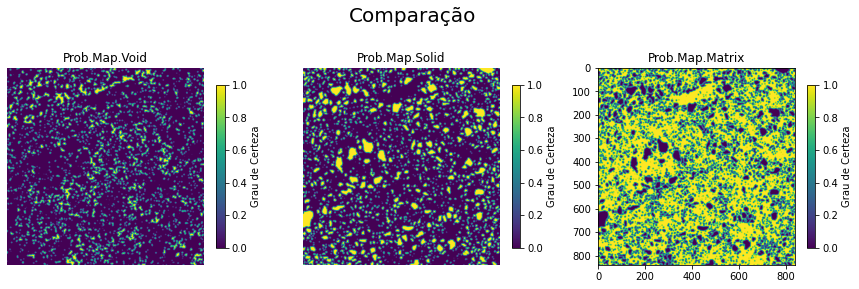

In [24]:
#Mapa de Probabilidade das marcações do Random Walker.
fig, axes = plt.subplots(nrows =1, ncols=3, figsize=(15, 15))
ax0, ax1, ax2 = axes
ax0.imshow(pm[0,1])
ax0.set_title('Prob.Map.Void',fontsize=12)
ax0.axis('off')
ax1.imshow(pm[0,1])
ax1.set_title('Prob.Map.Solid',fontsize=12)
ax1.axis('off')
ax2.imshow(pm[0,1])
ax2.set_title('Prob.Map.Matrix',fontsize=12)
cax2 = ax2.imshow(pm[2,1], interpolation='gaussian', vmin=0, vmax=1)
cax1 = ax1.imshow(pm[1,1], interpolation='gaussian', vmin=0, vmax=1)
cax0 = ax0.imshow(pm[0,1], interpolation='gaussian', vmin=0, vmax=1)
cb0 = fig.colorbar(cax0,ax=ax0,shrink=0.2)
cb1 = fig.colorbar(cax1,ax=ax1,shrink=0.2)
cb2 = fig.colorbar(cax2,ax=ax2,shrink=0.2)
cb0.ax.set_ylabel('Grau de Certeza', rotation=90)
cb1.ax.set_ylabel('Grau de Certeza', rotation=90)
cb2.ax.set_ylabel('Grau de Certeza', rotation=90)
fig.suptitle('Comparação', y=0.65, fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)